# Loan Repayment 
## Notebook 2: Exploratory Data Analysis (EDA)
<font size='3'>
This notebook will cover insights gained from exploring the transformed data. The important bits regarding data, assumptions made, and explanation made for each data transformation are covered in data_transform.ipynb. Therefore, this notebook will solely focus on creating visualizations and report findings. <b> It is highly recommended to go through data_transform.ipynb first </b> to understand the thought process of each decision made when processing the raw datasets.
<br><br>
As a reminder, the data used for loan repayment analysis here pertains to <b>funded loans that are completed (i.e. not ongoing)</b> during the time the database was pulled. 
</font>

In [1]:
import os
# Change directory to this file's directory
this_path = globals()['_dh'][-1]
os.chdir(this_path)
print("This file's directory:", os.getcwd())
# Change current path to parent of this file's directory
# to access all modules from parent
os.chdir('..')
source_path = os.getcwd()
print("Parent directory:", source_path)

This file's directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive/notebooks
Parent directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive


In [2]:
from main.data_loader import DataLoader
from main import viz_utils as viz
%matplotlib inline

In [3]:
# Load transformed data
os.chdir(source_path)
feather_path = os.path.join(str(os.getcwd()),'data-feathers') 
data_manager = DataLoader()
load_path = os.path.join(feather_path, 'transformed')
data_manager.load_feather(load_path)
print("Shape of transformed data:", data_manager.data.shape)

Shape of transformed data: (30672, 15)


In [4]:
# For plotting purposes, convert all categorical variables to dtype 'category'
data_manager.convert_dtype(origin='object', target='category')  # object (string) to category
data_manager.convert_dtype(origin='bool', target='category') # boolean to category
# Some are numeric, so have to list column name manually
to_cat = ['hasCF', 'applicationYear', 'nPaidOff']
data_manager.column_to_cat(to_cat)  # convert selected columns to 'category'
data_manager.display_types()


payFrequency                        category
apr                                  float64
nPaidOff                            category
loanStatus                          category
loanAmount                           float64
originallyScheduledPaymentAmount     float64
state                               category
leadType                            category
leadCost                               int64
fpStatus                            category
hasCF                               category
applicationYear                     category
paymentAmount                        float64
paidOff                             category
clearfraudscore                      float64
dtype: object

Text(0.5, 0.98, 'Distribution of Categorical variables')

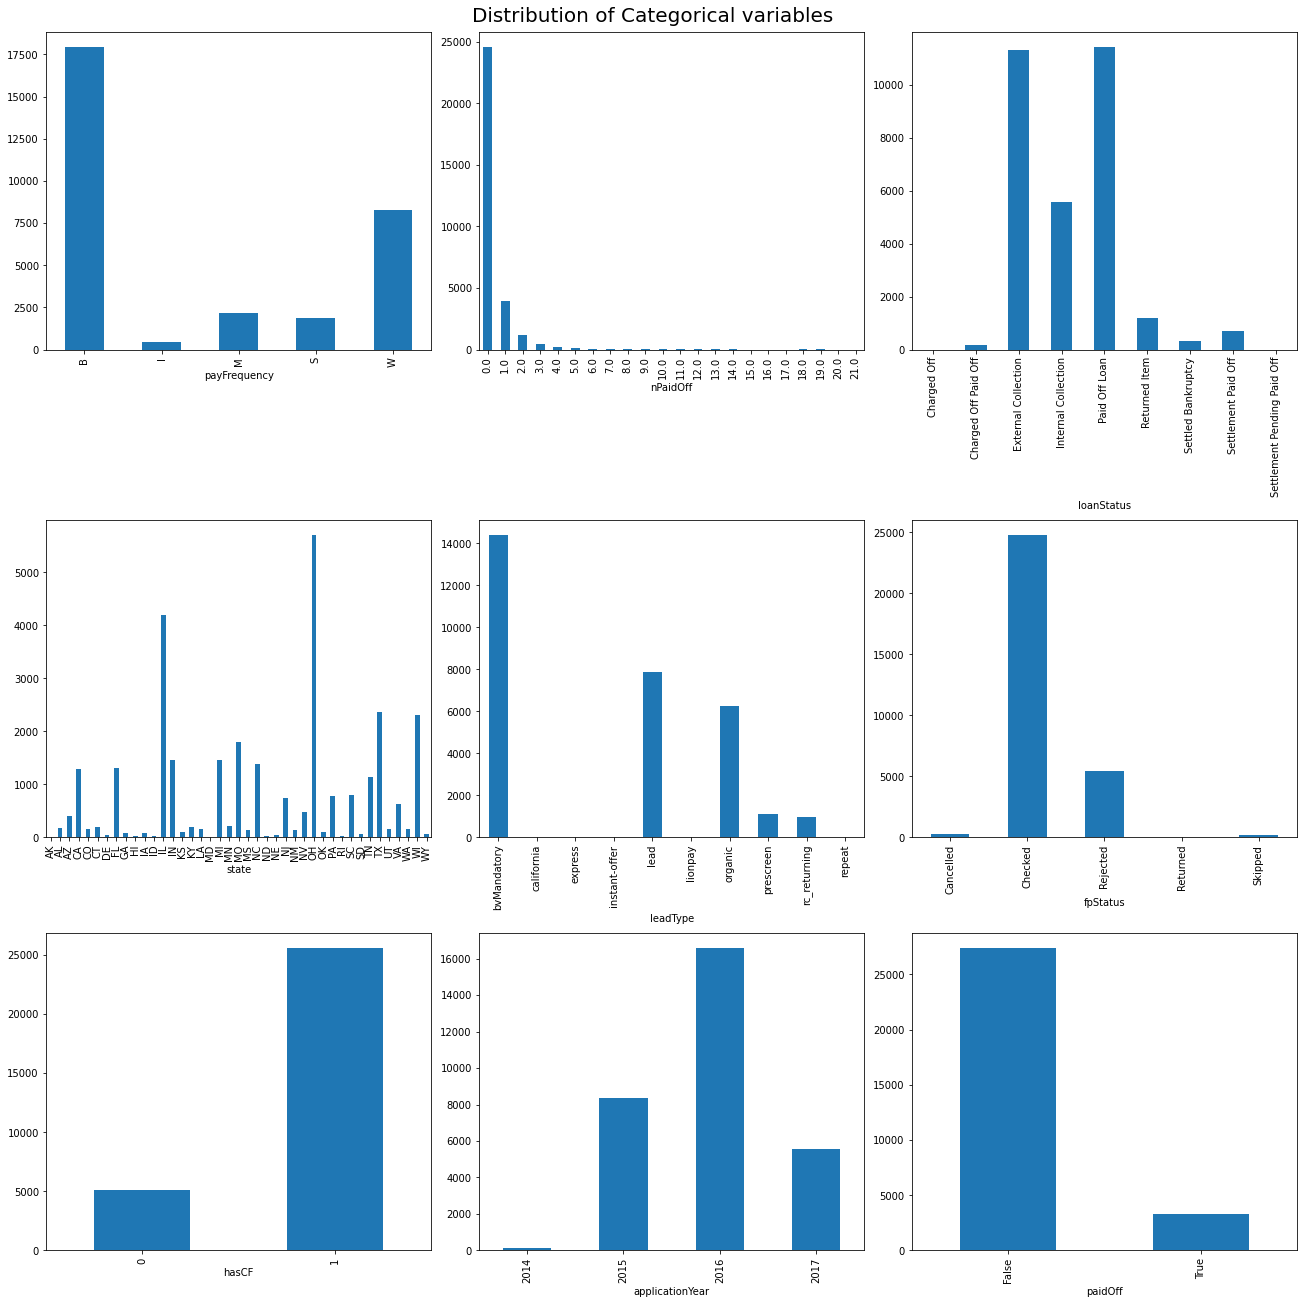

In [5]:
# For each categorical variable, Plot the count for each unique value
cols_unique_freq = data_manager.get_cols_unique_freq(datatype='category')
fig, axes = viz.bar_subplots(cols_unique_freq, subrow=3, figsize_ep=6)
fig.suptitle('Distribution of Categorical variables', fontsize=20)

<font size='3'> Key insights from distribution of individual categorical variables:</font>

- <font size='3'><b>There is an imbalance for the target variable 'paidOff'</b>. Therefore this gives insight that using ranking metrics such as ROC-AUC is more appropriate than accuracy for modelling.</font><br><br>
- <font size='3'> TA significant portion of funded loans are not paid off.</font><br><br> 
- <font size='3'> A very large number of (funded) loan applicants have no record of paying off their loans with the company (disregarding how many times they applied/funded before).</font><br><br>
- <font size='3'> About 5/6 of funded applicants have cash flow.</font><br><br> 
- <font size='3'> Most funded loan applicants opt for biweekly payments.</font><br><br>
- <font size='3'> The year 2016 has the highest number of completed funded loans (since the database was pulled).</font>


Text(0.5, 0.98, 'Distribution of Continuous Numerical Variables')

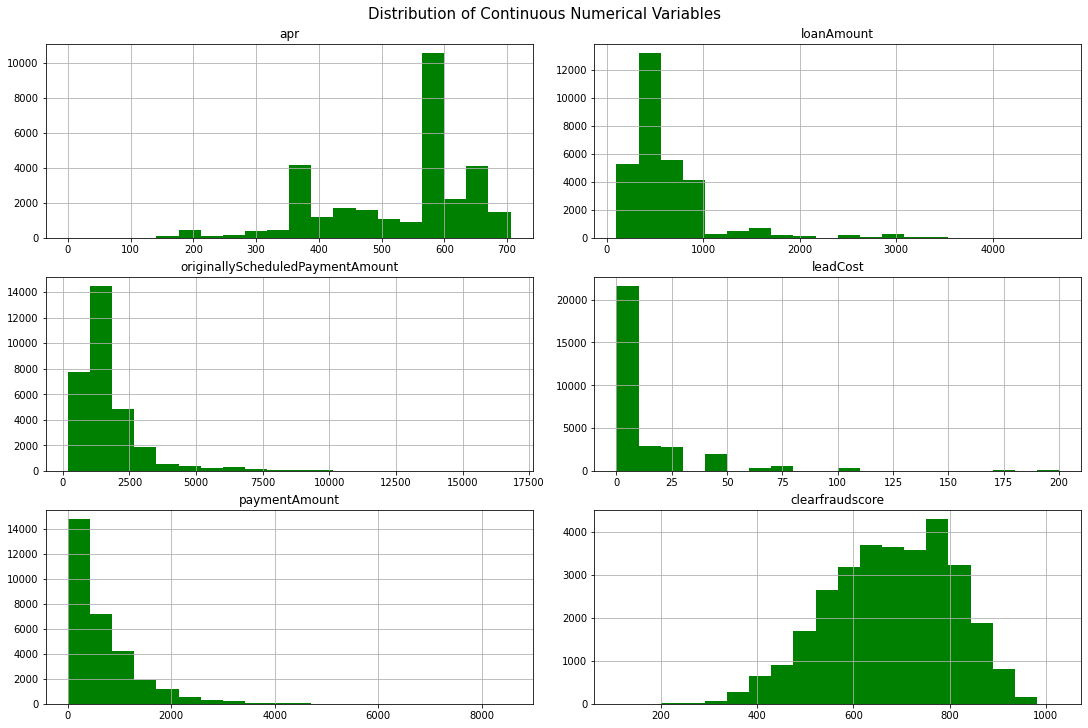

In [6]:
# Plot historgram for each Continuous variable
cont_cols = data_manager.data.select_dtypes(include=['int64', 'float64'])
fig, axes = viz.hist_subplots(df=cont_cols, subrow=3, figsize_ep=5, nbins=20)
fig.suptitle('Distribution of Continuous Numerical Variables', fontsize=15)


<font size='3'> Key insights from distribution of continuous variables:</font>

- <font size='3'> Overall, the distribution for each variable is skewed, and there are outliers mostly in loan/payment amounts.</font><br><br>
- <font size='3'> A very large proportion of loan amounts are below $1000.</font><br><br>
- <font size='3'> Most annual percentage rate are set around 6% for funded loans. </font><br><br>
- <font size='3'> As seen previously, fraud score has a somewhat normal distribution with minimum skew among other variables.</font>

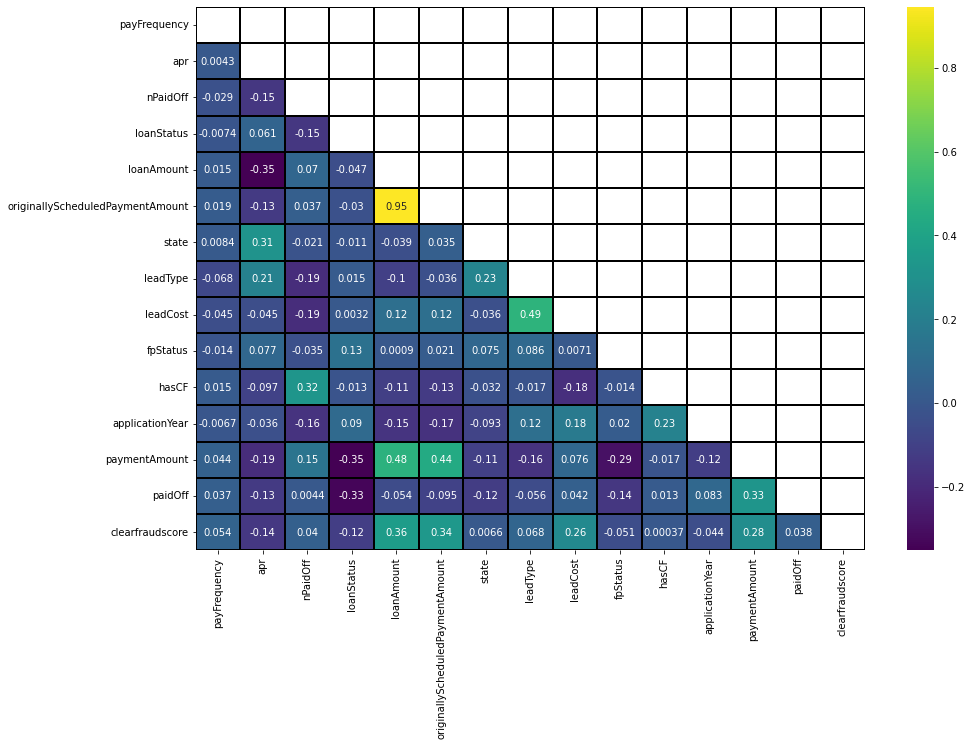

In [7]:
# Plot correlation between variables
data_manager.factorize_cat() #factorize categorical variables to allow correlation mapping
viz.heatmap(data_manager.data.corr())

<font size='3'> Key insights supported by correlation: </font>

- <font size='3'> The correlation heatmap largely serve for feature selection later for modelling, where generally highly correlated independent variables should be removed to reduce redundancy. </font> <br><br>
- <font size='3'> Loan amount and scheduled amount has very high correlation as expected, since scheduled amount is derived from loan amount. </font><br><br>
- <font size='3'> Hence, scheduled amount should be disregarded as a predictor for having high dependency towards loan amount.</font><br><br>
- <font size='3'> The target variable is derived from scheduled amount and payment amount, so it is logical to not use variables that contribute to the target variable formation as predictors. This decision is supported by the high correlation between the target variable and payment amount.</font><br><br>
- <font size='3'> Lead cost and lead type are highly correlated (statistically and logically), so we can remove either one. </font><br><br>
- <font size='3'> State, APR, and lead type have significant correlation, but logically, there should be no deliberate dependency applied during data collection, hence we can keep these variables as predictors.</font>

